In [1]:
import sys

if "/Users/shvimas/GitHub/diploma/src" not in sys.path:
    sys.path.append("/Users/shvimas/GitHub/diploma/src")

In [2]:
%matplotlib inline
from importlib import reload
import matplotlib.pyplot as pl
import data_helpers as dh
import ls_pricing as ls
from pars_range import Range, ParsRange
import numpy as np

pl.rcParams["figure.figsize"] = (15, 10)

In [3]:
pl.rcParams["figure.figsize"] = (15, 10)

In [4]:
try:
    data, info = dh.read_data("../SPH2_031612.csv")
except FileNotFoundError:
    data, info = dh.read_data("SPH2_031612.csv")

In [5]:
day = 0
rate = .03
q = rate
maturity = info[day].mat / len(info)
spot = info[day].spot
is_call = True
strikes = data.strikes[is_call][day]
prices = data.prices[is_call][day]
    
strikes = strikes[:-10]
prices = prices[:-10]

args = (spot, strikes, maturity, rate, q, is_call)

In [6]:
ls = reload(ls)

In [7]:
alpha_range = Range(min=1.417, max=1.417, num=1)
sigma_range = Range(min=.05, max=.09, num=20)

pars = ParsRange(model="ls", center=(1.417, .0718), widths=(.4, .02), dots=64)
pars.alpha_range = alpha_range
pars.sigma_range = sigma_range
print(pars.alpha_range.num)
print(pars.sigma_range.num)

1
20


In [8]:
predicted_alpha = []
for alpha, sigma in pars:
    predicted_alpha.append(strikes)
    predicted_alpha.append(ls.price_ls(pars=(alpha, sigma), args=args))

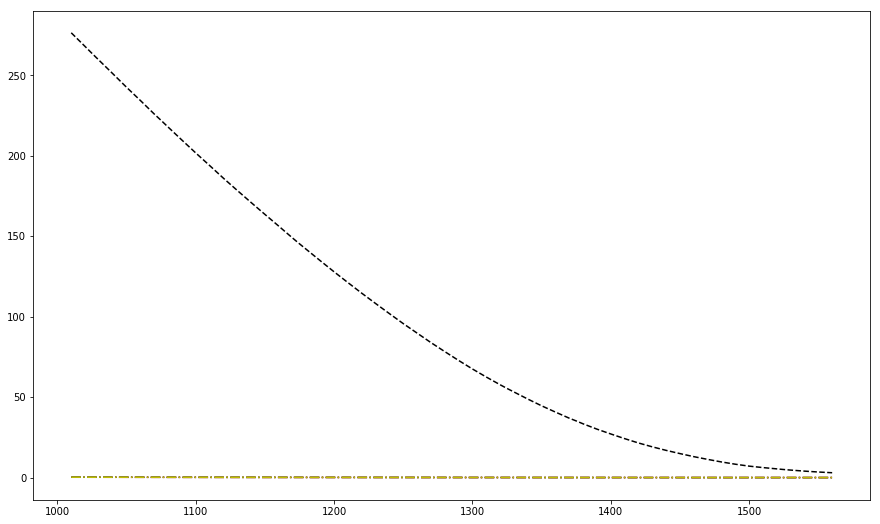

In [13]:
from structs import EvalArgs
args2 = EvalArgs.from_tuple(args)
args2.r = 0.0001

p = pl.plot(#*predicted_alpha, 
            strikes, prices, "k--", 
            strikes, ls.price_ls(pars=(1.41737596,  0.07191287), args=args2.as_tuple()), "r-.",
            strikes, ls.price_ls(pars=(1.32695262,  0.06663197), args=args), "m-.",
            strikes, ls.price_ls(pars=(1.14185719,  0.07361844), args=args2.as_tuple()), "g-.",
            strikes, ls.price_ls(pars=(1.02077429,  0.06171594), args=args2.as_tuple()), "y-.")

In [20]:
from optimization import robust_mean_ratio, mean_ratio
print(mean_ratio(predicted=ls.price_ls(pars=(1.99954862563, 0.999870404431), args=args), actual=prices))
mean_ratio(predicted=ls.price_ls(pars=(1.99954862563, 0.999870404431), args=args2.as_tuple()), 
           actual=prices)

32.4230519263


31.928819510230703

In [15]:
args2 = EvalArgs()
args2.r = .03
args2.q = .03
args2.maturity = .001
args2.strikes = np.array([100, 110, 90])
args2.spot = 100
args2.is_call = True

ls.price_ls(pars=(1.41737596,  1.7191287), args=args2.as_tuple())

array([  1.21874473e-02,   1.27236926e-06,   1.02817689e-01])

In [23]:
import modeling
modeling = reload(modeling)
ls = reload(ls)

In [36]:
res = modeling.tune_model(args=EvalArgs.from_tuple(args), 
                          model="ls", metric="mean ratio", prices=prices, 
                          bounds=((1.3, 1.5), (.05, .1)))

In [37]:
res

     fun: 1.0138516474592218
     jac: array([ 0.08844161,  0.23493294])
 message: 'Optimization terminated successfully.'
    nfev: 279
     nit: 6
 success: True
       x: array([ 1.35702891,  0.06854932])

In [21]:
new_args = EvalArgs.from_tuple(args)
new_args.r = .0001

In [29]:
res = modeling.tune_model(args=new_args, 
                          model="ls", metric="MAE", prices=prices, 
                          bounds=((1.001, 1.999), (.005, 1)))


In [30]:
res

     fun: 1.6728905274563299
     jac: array([ 3.35750578,  4.13793251])
 message: 'Optimization terminated successfully.'
    nfev: 669
     nit: 18
 success: True
       x: array([ 1.02077429,  0.06171594])

In [ ]:
def relative_diff(f, pars, args, prices):
    predicted = f(pars=pars, args=args)
    return (predicted - prices) / prices


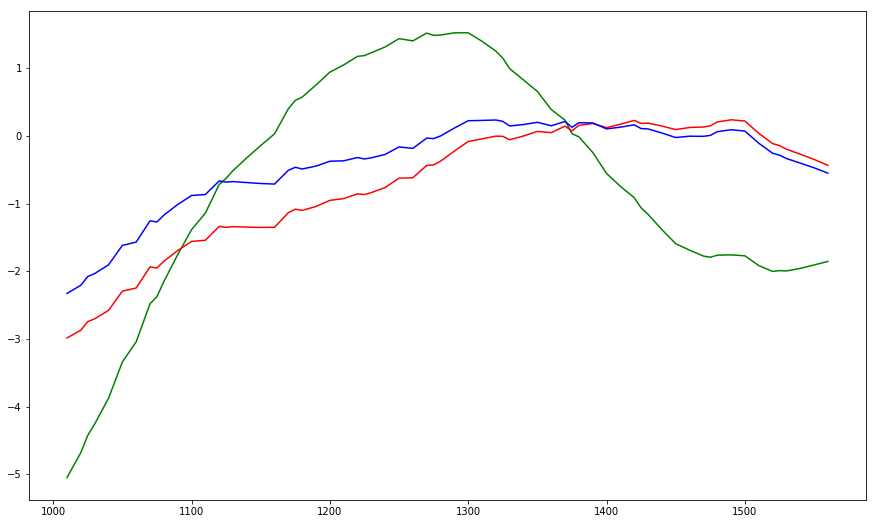

In [40]:
pl.plot(strikes, ls.price_ls(args=new_args.as_tuple(), pars=(1.06083698,  0.06261838)) - prices, "g",
        #strikes, ls.price_ls(args=new_args.as_tuple(), pars=(1.97393441,  0.02528949)) - prices, "y",
        strikes, ls.price_ls(pars=(1.35702891,  0.06854932), args=args) - prices, "r",
        strikes, ls.price_ls(pars=(1.34293434,  0.06775655), args=args) - prices, "b")


In [30]:
import numpy as np

print(np.mean(ls.price_ls(pars=(1.34293434,  0.06775655), args=args) - prices))
print(np.mean(ls.price_ls(pars=(1.06083698,  0.06261838), args=new_args.as_tuple()) - prices))

-0.413911480952
-0.710102857863


In [13]:
import warnings
warnings.filterwarnings("ignore", message='numpy.dtype size changed')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings('ignore', message="can't resolve package from __spec__ or __package__, ")

In [8]:
import data_helpers as dh
import numpy as np
import sklearn.decomposition as de


dh = reload(dh)


filename1 = dh.get_filename(model='ls', metric='MAE', best=True, is_call=True)
centers1 = np.array(list(dh.extract_centers(filename1)))
pca1 = de.PCA(n_components=2)
pca1.fit(centers1)
print(pca1.explained_variance_ratio_)
components1 = pca1.components_

filename2 = dh.get_filename(model='ls', metric='MAE', best=True, is_call=False)
centers2 = np.array(list(dh.extract_centers(filename2)))
pca2 = de.PCA(n_components=2)
pca2.fit(centers2)
print(pca2.explained_variance_ratio_)
components2 = pca2.components_

[ 0.9871125  0.0128875]
[ 0.98024352  0.01975648]


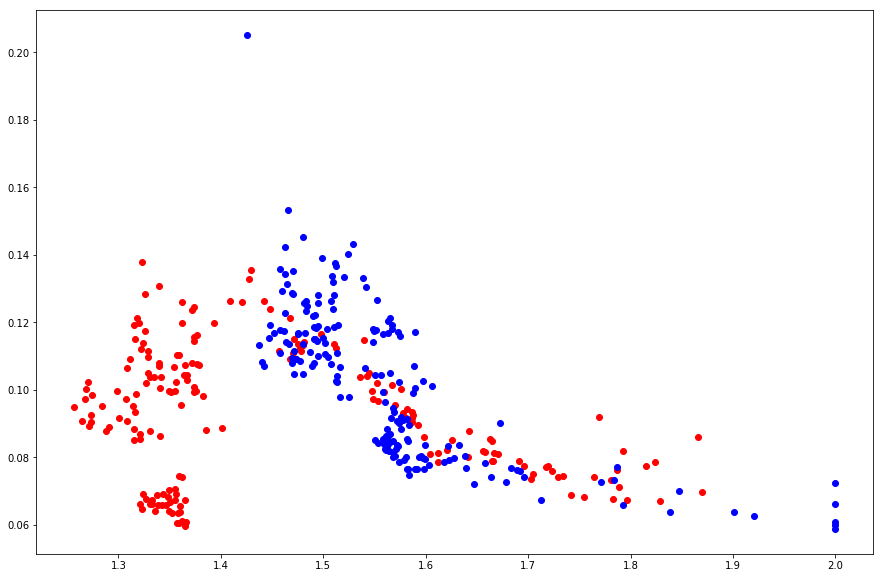

In [9]:
dh.plot_dots(centers1, centers2)

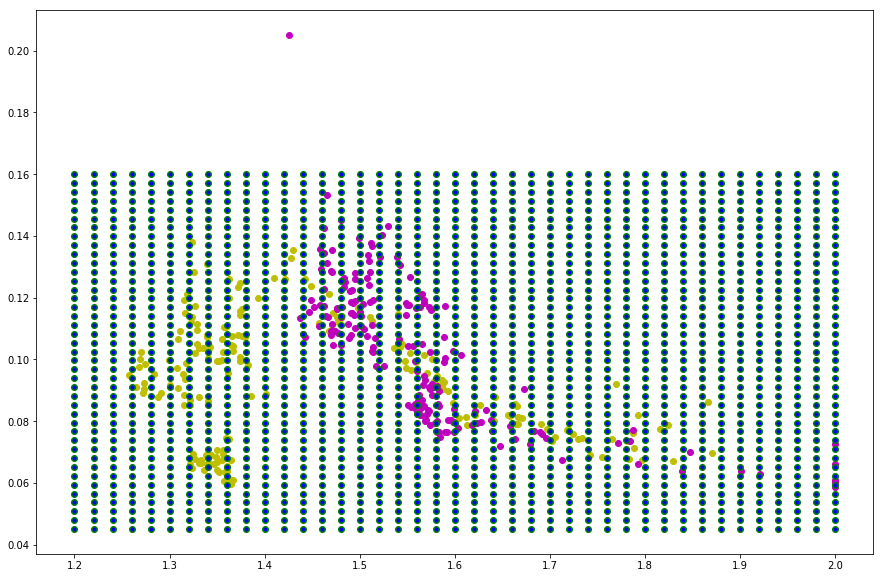

In [15]:
common_grid = np.array(dh.grid(1.2, 2., 0.045, .16, n=40))

dh.plot_dots(centers1, centers2, style1='yo', style2='mo')
dh.plot_and_color_2d_params(model='ls', dots=common_grid, 
                            factors=np.array([[1, 0], [0, 1]]), means=np.zeros(2), 
                            style_good='go', style_bad='ro', bounds_only=False)
dh.plot_and_color_2d_params(model='ls', dots=common_grid, 
                            factors=np.array([[1, 0], [0, 1]]), means=np.zeros(2),
                            style_good='b.', style_bad='r.', bounds_only=False)

In [18]:
import data_helpers as dh
import numpy as np
with open('params/pca_ls.txt', 'w') as f:
    f.writelines([f"{1.00001}, {1.9}, {0.02}, {0.16}\n",
                  f"{dh.array2str(np.array([[1, 0], [0, 1]]))}\n",
                  f"{dh.array2str(np.zeros(2))}\n",
                  f"{1.4}, {1.99999}, {0.03}, {0.18}\n",
                  f"{dh.array2str(np.array([[1, 0], [0, 1]]))}\n",
                  f"{dh.array2str(np.zeros(2))}\n"])

In [11]:
print(components1, components2)

[[ 0.99946691 -0.03264816]
 [ 0.03264816  0.99946691]] [[ 0.98911067 -0.14717366]
 [ 0.14717366  0.98911067]]


In [16]:
components1 @ np.array([[1, 0], [0, 1]]) + np.zeros(2)

array([[ 0.99946691, -0.03264816],
       [ 0.03264816,  0.99946691]])